In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix

In [123]:
dataset = pd.read_json('dataset/financialData.json')
dataset.drop(dataset[(dataset.sentiment >= -0.1) & (dataset.sentiment <= 0.1)].index, inplace=True)

In [124]:
len(dataset)

2583

In [125]:
X = dataset['title']
y = np.asarray([1 if s >= 0 else 0 for s in dataset['sentiment']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
import re
def text_preprocess(sentence):
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    #sentence = re.sub('\$\S*', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [127]:
X_train[:1]

656    Downbeaten stocks may be ripe for buys 
Name: title, dtype: object

In [128]:
tokenizer_obj =  Tokenizer()

tokenizer_obj.fit_on_texts(dataset['title'])

max_length = max([len(s.split()) for s in dataset['title']])

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [129]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
history = model.fit(X_train_pad, y_train, batch_size=256, epochs=30, verbose=2, validation_data=(X_test_pad, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2066 samples, validate on 517 samples
Epoch 1/30
 - 2s - loss: 0.6688 - accuracy: 0.6288 - val_loss: 0.6573 - val_accuracy: 0.6344
Epoch 2/30
 - 1s - loss: 0.6621 - accuracy: 0.6288 - val_loss: 0.6592 - val_accuracy: 0.6344
Epoch 3/30
 - 1s - loss: 0.6624 - accuracy: 0.6288 - val_loss: 0.6586 - val_accuracy: 0.6344
Epoch 4/30
 - 1s - loss: 0.6571 - accuracy: 0.6288 - val_loss: 0.6523 - val_accuracy: 0.6344
Epoch 5/30
 - 1s - loss: 0.5751 - accuracy: 0.6733 - val_loss: 0.5375 - val_accuracy: 0.7582
Epoch 6/30
 - 1s - loss: 0.2824 - accuracy: 0.9046 - val_loss: 0.6784 - val_accuracy: 0.7911
Epoch 7/30
 - 1s - loss: 0.1683 - accuracy: 0.9477 - val_loss: 0.5991 - val_accuracy: 0.7718
Epoch 8/30
 - 1s - loss: 0.1376 - accuracy: 0.9603 - val_loss: 0.7762 - val_accuracy: 0.7718
Epoch 9/30
 - 1s - loss: 0.0884 - accuracy: 0.9758 - val_loss: 0.9046 - val_accuracy: 0.7892
Epoch 10/30
 - 1s - loss: 0.0635 - accuracy: 0.9826 - val_loss: 0.7837 - val_accuracy: 0.7795
Epoch 11/30
 - 1s - lo

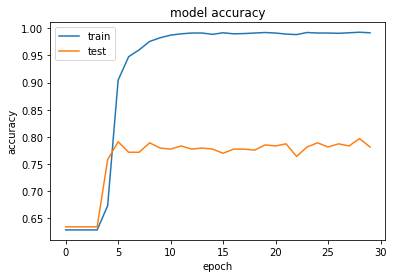

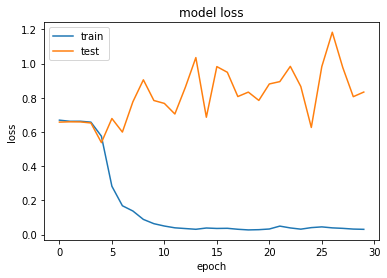

In [132]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [133]:
y_pred = model.predict_classes(X_test_pad)
confusion_matrix(y_pred ,y_test)

array([[111,  35],
       [ 78, 293]], dtype=int64)

In [134]:
def getModelError(y_pred, y_test, X_test):
    X_test_list = X_test.tolist()
    falsePositiveSentence = []
    falseNegativeSentence = []
    for i in range(0,len(y_pred)):
        if y_test[i] == 1 and y_pred[i] == 0:
            falsePositiveSentence.append(X_test_list[i])
        elif y_test[i] == 0 and y_pred[i] == 1:
            falseNegativeSentence.append(X_test_list[i])
    return (falsePositiveSentence, falseNegativeSentence)

In [135]:
falsePositive, falseNegative = getModelError(y_pred, y_test, X_test)

In [136]:
falsePositive

['watch $TSLA > 34.5 ',
 'Eli Lilly & Co. (LLY) Has Broken Out To A New High On AstraZeneca Collaboration',
 'UK MORNING BRIEFING: Sky And Hargreaves Lansdown Bookend FTSE 100',
 "Britain's FTSE steadies below record high, BHP gains",
 'lets see 14+ today ',
 'short didnt work out ',
 'weakness could be opportunity Good to sell Nov Put for re-entry ',
 'hanging tough in down market due to analyst upgrades Up almost 3% ',
 'FTSE 100 movers: BG Group leads the charge as resource stocks jump',
 'European shares fall on Chinese import data, SABMiller soars',
 '$SPY up only 0.6% Still holding ',
 'UPDATE: CIB, Legal & General Sell Egyptian Life Joint Venture To AXA',
 'may be ripe for a #takeover targe ',
 'Tesco boss urges rethink on minimum wage and business rates',
 "UPDATE 1-Britain's Tullow says makes new oil find in Kenya",
 'Cisco-Synata deal is a game-changer $CSCO ',
 'L&G fund arm, Nikko Asset Management sign bond fund distribution deal',
 'Daily Mail And General Trust eyeing Yaho